# Data Loading and embedding
In this notebook, we do
1. load toyzero raw window data
1. generate masks
1. patchify and embedding

**To-consider:**
1. mask generating probably should be combined with embedding

In [1]:
import numpy as np
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [3]:
%load_ext autoreload
%autoreload 2

from transformer import *

# Paired Toyzero data
Since this dataset was originally the test dataset of cycleGAN and used exclusively for test purpose, in order to use it as both train and test data for this supervised training, we set the first $1000$ pair of images for training and the remaining for test.

In [4]:
def load_image_fnames(dirname):
    """
    load image fnames.
    If amax_dataset_size is not infinity and is less than all available images,
    return a random subset of max_dataset_size image fnames.
    """
    assert Path(dirname).exists(), f"{dirname} doesn't exist"
    image_fnames = np.array(sorted(list(Path(dirname).glob('*npz'))))
    return image_fnames


class ToyzeroAlignedDataset(Dataset):
    def __init__(
            self, 
            dataroot, *, 
            max_dataset_size, 
            serial_batches, 
            train
    ):
        super(ToyzeroAlignedDataset, self).__init__()

        self.serial_batches = serial_batches

        dir_A = Path(dataroot)/f'testA'
        dir_B = Path(dataroot)/f'testB'
        self.image_fnames_A = load_image_fnames(dir_A)
        self.image_fnames_B = load_image_fnames(dir_B)
        
        if train:
            self.image_fnames_A = self.image_fnames_A[:1000]
            self.image_fnames_B = self.image_fnames_B[:1000]
        else:
            self.image_fnames_A = self.image_fnames_A[1000:]
            self.image_fnames_B = self.image_fnames_B[1000:]

        assert len(self.image_fnames_A) == len(self.image_fnames_B), "The dataset is not aligned"
        
        aligned = True
        for fname_A, fname_B in zip(self.image_fnames_A, self.image_fnames_B):
            if fname_A.stem != fname_B.stem:
                aligned = False
                break
        if not aligned:
            print("The dataset is not aligned")
            exit()

        self.size = len(self.image_fnames_A)

        if max_dataset_size != float('inf') and max_dataset_size < self.size:
            indices = np.arange(self.size)
            np.random.shuffle(indices)
            indices = indices[:max_dataset_size]
            self.image_fnames_A = self.image_fnames_A[indices]
            self.image_fnames_B = self.image_fnames_B[indices]
            self.size = max_dataset_size

    def __len__(self):
        return self.size

    def __load(self, image_fname):
        image = np.load(image_fname)
        image = image[image.files[0]]
        image = np.expand_dims(np.float32(image), 0)
        return image

    def __getitem__(self, index):
        if self.serial_batches:
            index = index % self.size
        else:
            index = np.random.randint(0, self.size - 1)
        
        image_A = self.__load(self.image_fnames_A[index])
        image_B = self.__load(self.image_fnames_B[index])

        
        return {
            'A': image_A, 
            'B': image_B, 
        }


# Patchify and depatchify

In [5]:
def patchify(x, patch_size):
    """
    Cut a batch of images into non-overlapping patches and stack them
    Input:
        - x (Tensor): The input tensor with shape (batch_size(N), n_channels(C), width(W), height(H));
        - patch_size (int): the side length of the patch, which means each patch is of size (patch_size, patch_size);
    Output:
        Tensor of shape (batch_size * num_patches, n_channel, patch_size, patch_size).
        The first 1 through num_patches belongs to the first image 
        and the num_patches + 1 through 2 * num_patches belongs to the second image, etc.
    """
    batch_size = x.size(0)
    image_size = x.size(-1)
    patches = [
        x[b, :, i: i + patch_size, j: j + patch_size].unsqueeze(0)
        for b in range(batch_size)
        for i in range(0, image_size, patch_size)
        for j in range(0, image_size, patch_size)
    ]
    return torch.cat(patches, dim=0)


def depatchify(x, batch_size):
    """
    Assemble the patches back to a image.
    NOTE: We assume that both the image and patch are square.
    Input:
        - x (Tensor): The input tensor with shape (batch_size * num_patches, n_channel, patch_size, patch_size)
        - batch_size (int): number of FULL images in a batch
    """
    patch_size = x.size(-1)
    # Number of patches per image
    num_patches = x.size(0) // batch_size
    # Number of patches along each edge
    num_patches_edge = int(np.sqrt(num_patches))
    
    patches = x.view(-1, num_patches, *x.shape[1:])
    images = []
    for I in patches:
        rows = []
        for i in range(num_patches_edge):
            start = i * num_patches_edge
            row = torch.cat([I[start + j] for j in range(num_patches_edge)], dim=-1)
            rows.append(row)
        image = torch.cat(rows, dim=-2)
        image = torch.unsqueeze(image, 0)
        images.append(image)
    return torch.cat(images, dim=0)


# ================================= Test  ================================= 
patch_size = 4
image_size = 8
batch_size = 2

x = np.random.randint(0, 10, size=(batch_size, 2, image_size, image_size))
x = torch.from_numpy(x)
p = patchify(x, patch_size)
print(p.shape)
y = depatchify(p, batch_size)
print(x == y)

torch.Size([8, 2, 4, 4])
tensor([[[[True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True]],

         [[True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True]]],


        [

# Embedding and Generator

## Embedding

In [6]:
class Embedding(nn.Module):
    def __init__(self, d_model, image_size, patch_size, mode='conv', leading=True, source=True):
        """
        Input:
            - d_model (int): the embedding dimension
            - image_size (int): We assume square images and image_size is the side length of the square
            - patch_size (int): We assume square patches and patch_size is the side length of the square
            - mode (str): choose one from ['plain', 'conv', 'fourier']
                - plain: normalization + linear (2 * d_model) + activation + normalization + linear (TO BE IMPLEMENTED)
                - conv: convolution
                - fourier: 2d-fourier embedding (TO BE IMPLEMENTED)
            - leading (bool): Whether there is a leading "token" indicating the start of a sequence
        """
        super(Embedding, self).__init__()
        self.d_model = d_model
        self.image_size = image_size
        self.patch_size = patch_size
        self.leading = leading
        self.source = source
        if not leading:
            self.source = False
        
        if mode == 'conv':
            num_patches = (image_size // patch_size) ** 2
            
            num_layers = self.get_exp(patch_size)
            if num_layers == -1:
                raise ValueError(f"patch_size ({patch_size}) is not a power of 2")
                
            num_channel_base = 2 ** (num_layers - 1)
            assert d_model % num_channel_base == 0, \
                f"d_model ({d_mode}) is not a multiple of ({num_channel_base})"
            
            conv_blocks = []
            in_channels = 1
            out_channels = d_model // num_channel_base
            for i in range(num_layers - 1):
                conv_blocks += [
                    nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1), 
                    nn.BatchNorm2d(out_channels), 
                    nn.ReLU(),
                    # nn.LeakyReLU(negative_slope=.2)
                ]
                in_channels = out_channels
                out_channels *= 2
            conv_blocks.append(nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1))
            self.layers = nn.ModuleList(conv_blocks)
        else:
            raise NotImplementedError(f"{mode} embedding is not implemented")
    
    @staticmethod
    def get_exp(num):
        exp = 0
        while num % 2 == 0:
            num, exp = num // 2, exp + 1
        return -1 if num != 1 else exp       
    
    def forward(self, x):
        batch_size = x.size(0)
        num_patches = (x.size(-1) // self.patch_size) ** 2
        
        assert all([s == self.image_size for s in x.shape[-2:]]), \
            f"input image must have size ({self.image_size} x {self.image_size}) but input tensor has shape ({x.shape})."
        p = patchify(x, self.patch_size)
        for i, layer in enumerate(self.layers):
            p = layer(p)
            
        p = p.squeeze()
        
        # ADD ANNOTATION HERE
        tokenized_images = []
        for start in range(0, p.size(0), num_patches):
            tokenized_image = p[start: start + num_patches]
            if self.leading:
                # Now, the tokenized_image is of shape (seq_len, embedding_length), and
                # we need to add one row of ones as the top row.
                # The parameter 'pad' is in the order (left, right, top, bottom).
                tokenized_image = F.pad(tokenized_image, pad=(0, 0, 1, 0), mode='constant', value=1)
#                 if not self.source:
#                     tokenized_image = tokenized_image[:-1]
                # print(f'padded {tokenized_image}')
            tokenized_image = tokenized_image.unsqueeze(0)
            tokenized_images.append(tokenized_image)
        T = torch.cat(tokenized_images, dim=0)    
        return T * np.sqrt(self.d_model)

## Generator

In [7]:
class Generator(nn.Module):
    """
    Define standard linear + softmax generation step.
    """
    def __init__(self, d_model, image_size, patch_size, mode='conv', leading=True):
        """
        Input:
            - d_model (int): the embedding dimension
            - image_size (int): We assume square images and image_size is the side length of the square
            - patch_size (int): We assume square patches and patch_size is the side length of the square
            - mode (str): choose one from ['plain', 'conv', 'fourier']
                - plain: normalization + linear (2 * d_model) + activation + normalization + linear (TO BE IMPLEMENTED)
                - conv: convolution
                - fourier: 2d-fourier embedding (TO BE IMPLEMENTED)
            - leading (bool): Whether there is a leading "token" indicating the start of a sequence
        """
        super(Generator, self).__init__()
        self.d_model = d_model
        self.image_size = image_size
        self.patch_size = patch_size
        self.leading = leading
        if mode == 'conv':
            num_patches = (image_size // patch_size) ** 2
            
            num_layers = self.get_exp(patch_size)
            if num_layers == -1:
                raise ValueError(f"patch_size ({patch_size}) is not a power of 2")
                
            num_channel_base = 2 ** (num_layers - 1)
            assert d_model % num_channel_base == 0, \
                f"d_model ({d_mode}) is not a multiple of ({num_channel_base})"
            
            conv_blocks = []
            in_channels = d_model
            for i in range(num_layers - 1):
                out_channels = in_channels // 2
                conv_blocks += [
                    nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1), 
                    nn.BatchNorm2d(out_channels), 
                    nn.ReLU(),
                    # nn.LeakyReLU(negative_slope=.2)
                ]
                in_channels = out_channels
            conv_blocks.append(nn.ConvTranspose2d(in_channels, 1, kernel_size=4, stride=2, padding=1))
            self.layers = nn.ModuleList(conv_blocks)
        else:
            raise NotImplementedError(f"{mode} embedding is not implemented")
    
    @staticmethod
    def get_exp(num):
        exp = 0
        while num % 2 == 0:
            num, exp = num // 2, exp + 1
        return -1 if num != 1 else exp
    
    def forward(self, x):
        """
        Input:
            - x (Tensor): tensor of shape (batch_size, seq_len, d_model)
        """
        batch_size = x.size(0)
        
        # 1) Stack the embedded tokens from each sequence 
        #    and get a tensor of shape (batch_size x seq_len, d_model).
        if self.leading:
            x = torch.cat([tokenized_image[1:] for tokenized_image in x], dim=0)
        else:
            x = torch.cat([tokenized_image for tokenized_image in x], dim=0)
        # x = torch.cat([tokenized_image for tokenized_image in x], dim=0)
        # 2) Add width=1 and height=1 to the end of the tensor and 
        #    get a tensor of shape (batch_size x seq_len, d_model, 1, 1).
        x = x.unsqueeze(-1).unsqueeze(-1)
        # 3) Apply deconvolution, decrease the number of freatures
        #    while increasing the image size, so that the output
        #    has shape (batch_size x seq_len, 1, patch_size, patch_size).
        for i, layer in enumerate(self.layers):
            x = layer(x)
        # 4) Depatchify the patches back to images.
        #    The seq_len is the number of patches, which is a square.
        #    The number of patches along each side, P, is the square root of seq_len
        #    The resulting tensor is of size 
        #    (batch_size, 1, patch_size * P, patch_size * P), 
        #    where patch_size * P is the side length of the original image.
        x = depatchify(x, batch_size)
        return x

## Test the Embedding and Generator

In [8]:
# # Set the device, either 'cuda' or 'cpu'
# device = 'cuda'

# # Load data
# dataroot='/sdcc/u/yhuang2/PROJs/GAN/datasets/ls4gan/toyzero_cropped/toyzero_1001_300-128x128_U/'
# max_dataset_size = 256
# serial_batches = True
# # batch_size = max_dataset_size
# batch_size = 32

# dataset = ToyzeroAlignedDataset(
#     dataroot, 
#     max_dataset_size=max_dataset_size, 
#     serial_batches=serial_batches, 
#     # patch_size=16
#     train=True
# )
# loader = DataLoader(dataset, batch_size=batch_size, shuffle=serial_batches)
# data = next(iter(loader))

# # Set parameter
# image_size = 128
# patch_size = 16
# d_model = 512
# leading = False

# # Embedding
# eb = Embedding(d_model, image_size, patch_size, mode='conv', leading=leading).to(device)
# embedding = eb(data['A'].to(device))
# print(embedding.shape)

# # Generator
# gr = Generator(d_model, image_size, patch_size, mode='conv', leading=leading).to(device)
# images = gr(embedding)
# print(images.shape)

# Embedding-generator network WITHOUT transformer in between
As a benchmark

In [9]:
class Simple(nn.Module):
    def __init__(self, embedding, generator):
        super(Simple, self).__init__()
        self.embedding = embedding
        self.generator = generator
        
    def forward(self, x):
        embedded = self.embedding(x)
        return self.generator(embedded)

## Utility functions for training

In [10]:
def SimplePlot(x, out, y, kwargs=None, symlog=True):
    
    num_samples = 5
    cmap = 'bwr'
    width = 4
    if kwargs:
        if 'num_samples' in kwargs:
            num_samples = kwargs['num_samples']
        if 'cmap' in kwargs:
            cmap = kwargs['cmap']
        if 'width' in kwargs:
            width = kwargs['width']
            
    print(num_samples)
    total_samples = x.size(0)
    indices = np.random.choice(total_samples, num_samples, replace=False)
    images = torch.stack([x[indices], out[indices], y[indices]]).squeeze().transpose_(0, 1).detach().cpu().numpy()
    
    width = 4
    fig, axes = plt.subplots(num_samples, 3, figsize=(3 * width * 1.1, num_samples * width))
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            ax.set_aspect(1)
            image = images[i][j]
            
            if symlog:
                im = ax.pcolormesh(
                    images[i][j], 
                    cmap=cmap, 
                    norm=mcolors.SymLogNorm(
                        linthresh=1, 
                        linscale=1,
                    )
                )
            else:
                vmin, vmax = image.min(), image.max()
                if vmin == 0:
                    vmin = -.05
                if vmax == 0:
                    vmax = .05
                divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
                im = ax.pcolormesh(images[i][j], cmap=cmap, norm=divnorm)
                
            # Color bar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(im, cax=cax, orientation='vertical')
    plt.tight_layout()
    
    # block=False for immediate plotting. 
    # Otherwise, the plots will show all at once at the end.
    plt.show(block=False) 
    
# # ========================== Test ==========================
# x = torch.randn(10, 1, 128, 128)
# out = torch.randn(10, 1, 128, 128)
# y = torch.randn(10, 1, 128, 128)
# plot(x, out, y)

In [11]:
def run_epoch(batches, model, loss_compute, logging_freq=50, plot_func=None, plot_kwargs=None):
    """
    Standard training and logging function
    """    
    start = time.time()
    total_loss = 0 # cumulative loss
    total_image = 0

    for i, batch in enumerate(batches):
        x = batch['A'].to(device)
        out = model(x)
        y = batch['B'].to(device)
        loss = loss_compute(out, y)
        num_images = batch['A'].size(0)
        total_loss += loss * batch['A'].size(0)
        total_image += num_images

        if logging_freq > 0:
            if i % logging_freq == logging_freq - 1:
                elapsed = time.time() - start
                print(f'\tIteration: {i + 1}')
                print(f'\t\tCurrent loss per image:\t{loss / num_images:.6f}')
                print(f'\t\tAvg. time per batch:\t{elapsed / logging_freq:.6f}')
                start = time.time()
    if plot_func:
        if plot_kwargs:
            plot_func(x, out, y, plot_kwargs)
        else:
            plot_func(x, out, y) 
            
    return total_loss / total_image

In [12]:
class NoamOpt:
    """
    Optim wrapper that implements learning rate.
    """
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

        self._a = self.factor * (self.model_size ** -.5)
        self._b = self.warmup ** (-1.5)

    def step(self):
        """
        update parameters and rate
        """
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate

        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        """
        Implement lr as defined above.
        """
        if step is None:
            step = self._step
        return self._a * min(step ** (-.5), step * self._b)

In [13]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

class LossCompute:
    """
    A simple loss compute and train function.
    """
    def __init__(self, criterion, opt=None):
        self.criterion = criterion
        self.opt = opt
    
    def __call__(self, x, y):
        loss = self.criterion(x, y)
        
        if self.opt is not None:
            loss.backward()
            self.opt.step()
            self.opt.optimizer.zero_grad()
        
        return loss.item()

## Train

In [14]:
# Set parameter
dataroot='/sdcc/u/yhuang2/PROJs/GAN/datasets/ls4gan/toyzero_cropped/toyzero_1001_300-128x128_U/'
# Set the device, either 'cuda' or 'cpu'
device = 'cuda'
image_size = 128
patch_size = 16
d_model = 512
leading = False

# # Load train data
# max_dataset_size = 1000
# serial_batches = True
# # batch_size = max_dataset_size
# batch_size = 32

# dataset = ToyzeroAlignedDataset(
#     dataroot, 
#     max_dataset_size=max_dataset_size, 
#     serial_batches=serial_batches, 
#     train=True
# )
# loader_train = DataLoader(dataset, batch_size=batch_size, shuffle=serial_batches)

# Load valid data
max_dataset_size = 100
serial_batches = True
batch_size = max_dataset_size
# batch_size = 32

dataset = ToyzeroAlignedDataset(
    dataroot, 
    max_dataset_size=max_dataset_size, 
    serial_batches=serial_batches, 
    train=False
)
loader_valid = DataLoader(dataset, batch_size=batch_size, shuffle=serial_batches)

checkpoint_folder = 'checkpoints/simple'
if not Path(checkpoint_folder).exists():
    Path(checkpoint_folder).mkdir(parents=True)
checkpoint_freq = 20

plot_freq = 20

In [15]:
# # Embedding
# eb = Embedding(d_model, image_size, patch_size, mode='conv', leading=leading)
# # Generator
# gr = Generator(d_model, image_size, patch_size, mode='conv', leading=leading)
# model = Simple(eb, gr).to(device)

# model_opt = NoamOpt(
#     d_model,
#     1, # factor
#     20, # warmup
#     torch.optim.Adam(model.parameters(), lr=0, betas=(.9, .98), eps=1e-9)
# )

# epochs = 200
# for epoch in range(epochs):
#     print(f'Epoch {epoch + 1} / {epochs}')
#     # tells your model that you are training the model. 
#     # So effectively layers like dropout, batchnorm etc. 
#     # which behave different on the train and test procedures 
#     # know what is going on and hence can behave accordingly.
#     model.train()
#     start = time.time()
#     old_lr = get_lr(model_opt.optimizer)
#     loss_train = run_epoch(
#         loader_train,
#         model,
#         LossCompute(nn.L1Loss(), model_opt),
#         logging_freq=-1
#     )
#     new_lr = get_lr(model_opt.optimizer)
#     print(f'\tlr:\t\t{old_lr:.6f} -> {new_lr:.6f}')
#     print(f'\ttime per epoch:\t{time.time() - start:.6f} seconds')
#     print(f'\ttrain loss:\t{loss_train:.6f}')
    
#     # Validation:
#     if epoch % plot_freq == plot_freq - 1:
#         plot_func = SimplePlot
#     else:
#         plot_func = None
    
#     loss_valid = run_epoch(
#         loader_valid,
#         model,
#         LossCompute(nn.L1Loss()), # don't use an optimizer and the loss won't be back propagated
#         logging_freq=-1, 
#         plot_func=plot_func,
#         plot_kwargs={'num_samples': 3}
#     )
#     print(f'\tvalid loss:\t{loss_valid:.6f}')
    
#     if epoch % checkpoint_freq == checkpoint_freq - 1:
#         print('\tSaving checkpoint')
#         fname = f'model_dict_{epoch + 1}'
#         torch.save(model.state_dict(), f'{checkpoint_folder}/{fname}.pt')
#         torch.save(model.state_dict(), f'{checkpoint_folder}/model_dict_last.pt')

# Transformer (Adding Attention)

## Make model

In [17]:
def make_model(
    image_size,
    patch_size, *,
    N=6,
    d_model=512,
    d_ff=2048,
    h=8,
    dropout=.1, 
    mode='conv',
    leading=True,
):
    """
    Construct a model from hyperparameters
    Input:
        - image_size (int): images are supposed to be square, and the image_size is the side length.
        - patch_size (int): patches are supposed to be square, and the patch_size is the side length.
        - N (int): number of encoder and decoder blocks.
        - d_model (int): d_model is the embedding length of each token. d_model must be divisible by h (number of heads).
        - d_ff (int): hidden units in the hidden layer of the feed-forward block.
        - h (int): number of heads in the multiheaded attention.
        - dropout (float): dropout rate used in many places in the network.
        - mode (string): way of embedding and generator.
        - leading (bool): whether to add a leading token to the embedded sequence (sequence of patches in our case).
    """

    C = copy.deepcopy

    attn = MultiHeadedAttention(h, d_model)
    ff = PositionWiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)

    encoder = Encoder(EncoderLayer(d_model, C(attn), C(ff), dropout), N)
    decoder = Decoder(DecoderLayer(d_model, C(attn), C(attn), C(ff), dropout), N)
    src_embedding = Embedding(d_model, image_size, patch_size, mode=mode, leading=leading, source=True)
    tgt_embedding = Embedding(d_model, image_size, patch_size, mode=mode, leading=leading, source=False)
    model = EncoderDecoder(
        encoder,
        decoder,
        nn.Sequential(src_embedding, C(position)),
        nn.Sequential(tgt_embedding, C(position)),
        Generator(d_model, image_size, patch_size, mode=mode)#, leading=leading)
    )

    # (author of this blog): This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

## Train (Embedding + Transformer + Generator)

In [18]:
# run_epoch needs to be modified since the feed forward part also need 
def run_epoch(batches, model, loss_compute, logging_freq=50, plot_func=None, plot_kwargs=None):
    """
    Standard training and logging function
    """    
    start = time.time()
    total_loss = 0 # cumulative loss
    total_image = 0

    for i, batch in enumerate(batches):
        x = batch['A'].to(device)
        y = batch['B'].to(device)
        out = model(x, y) # run_epoch needs to be modified since the feed forward part also need 
        
        loss = loss_compute(out, y)
        num_images = batch['A'].size(0)
        total_loss += loss * batch['A'].size(0)
        total_image += num_images

        if logging_freq > 0:
            if i % logging_freq == logging_freq - 1:
                elapsed = time.time() - start
                print(f'\tIteration: {i + 1}')
                print(f'\t\tCurrent loss per image:\t{loss / num_images:.6f}')
                print(f'\t\tAvg. time per batch:\t{elapsed / logging_freq:.6f}')
                start = time.time()
    if plot_func:
        if plot_kwargs:
            plot_func(x, out, y, plot_kwargs)
        else:
            plot_func(x, out, y) 
            
    return total_loss / total_image

In [19]:
checkpoint_folder = 'checkpoints/transformer_full'
if not Path(checkpoint_folder).exists():
    Path(checkpoint_folder).mkdir(parents=True)

In [20]:
model = make_model(image_size, patch_size, N=3, d_model=256).to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'number of parameters = {num_params/1024**2:.2f}M')

number of parameters = 10.25M


In [20]:
# model_opt = NoamOpt(
#     d_model,
#     1, # factor
#     20, # warmup
#     torch.optim.Adam(model.parameters(), lr=0, betas=(.9, .98), eps=1e-9)
# )

# epochs = 200
# for epoch in range(epochs):
#     print(f'Epoch {epoch + 1} / {epochs}')
#     # tells your model that you are training the model. 
#     # So effectively layers like dropout, batchnorm etc. 
#     # which behave different on the train and test procedures 
#     # know what is going on and hence can behave accordingly.
#     model.train()
#     start = time.time()
#     old_lr = get_lr(model_opt.optimizer)
#     loss_train = run_epoch(
#         loader_train,
#         model,
#         LossCompute(nn.L1Loss(), model_opt),
#         logging_freq=-1
#     )
#     new_lr = get_lr(model_opt.optimizer)
#     print(f'\tlr:\t\t{old_lr:.6f} -> {new_lr:.6f}')
#     print(f'\ttime per epoch:\t{time.time() - start:.6f} seconds')
#     print(f'\ttrain loss:\t{loss_train:.6f}')
    
#     # Validation:
#     if epoch % plot_freq == plot_freq - 1:
#         plot_func = SimplePlot
#     else:
#         plot_func = None
    
#     loss_valid = run_epoch(
#         loader_valid,
#         model,
#         LossCompute(nn.L1Loss()), # don't use an optimizer and the loss won't be back propagated
#         logging_freq=-1, 
#         plot_func=plot_func,
#         plot_kwargs={'num_samples': 3}
#     )
#     print(f'\tvalid loss:\t{loss_valid:.6f}')
    
#     if epoch % checkpoint_freq == checkpoint_freq - 1:
#         print('\tSaving checkpoint')
#         fname = f'model_dict_{epoch + 1}'
#         torch.save(model.state_dict(), f'{checkpoint_folder}/{fname}.pt')
#         torch.save(model.state_dict(), f'{checkpoint_folder}/model_dict_last.pt')
        
#     memory_cuda = torch.cuda.max_memory_allocated(device='cuda')
#     print(f'\tpeak memory use:\t{memory_cuda/1024 ** 3:.3f}G')

In [34]:
data = next(iter(loader_valid))
x = data['A'].to(device)
y = data['B'].to(device)
x_ = x[:5]
y_ = x[:5]
x_.shape

# model.load_state_dict(torch.load('checkpoints/transformer_full/model_dict_last.pt'))
# model_str = model.eval()
# out = model(x, y)


torch.Size([5, 1, 128, 128])

In [22]:
# SimplePlot(x, out, y, {'num_samples': 10, 'width': 4})

# Greedy Decoding

In [35]:
def greedy_decode(model, x, device):
    model.infer()
    
    with torch.no_grad():
        memory = model.encode(x)
        print(memory.shape)
        batch_size = memory.size(0)
        d_model = memory.size(-1)
        num_patches = memory.size(1) - 1

        ys = torch.ones(batch_size, 1, d_model).to(device)
#         memory_cuda = torch.cuda.max_memory_allocated(device='cuda')
#         print(f'\tpeak memory use:\t{memory_cuda/1024 ** 3:.3f}G')
        
        print(ys.shape)
        for i in range(num_patches):
#             memory_cuda = torch.cuda.max_memory_allocated(device='cuda')
#             print(f'{i}: \tpeak memory use:\t{memory_cuda/1024 ** 3:.3f}G')
            out = model.decode(memory, ys)[:, -1, :].unsqueeze(dim=1)
            ys = torch.cat([ys, out], dim=1)

        return model.generator(ys)

torch.Size([5, 65, 256])
torch.Size([5, 1, 256])
5


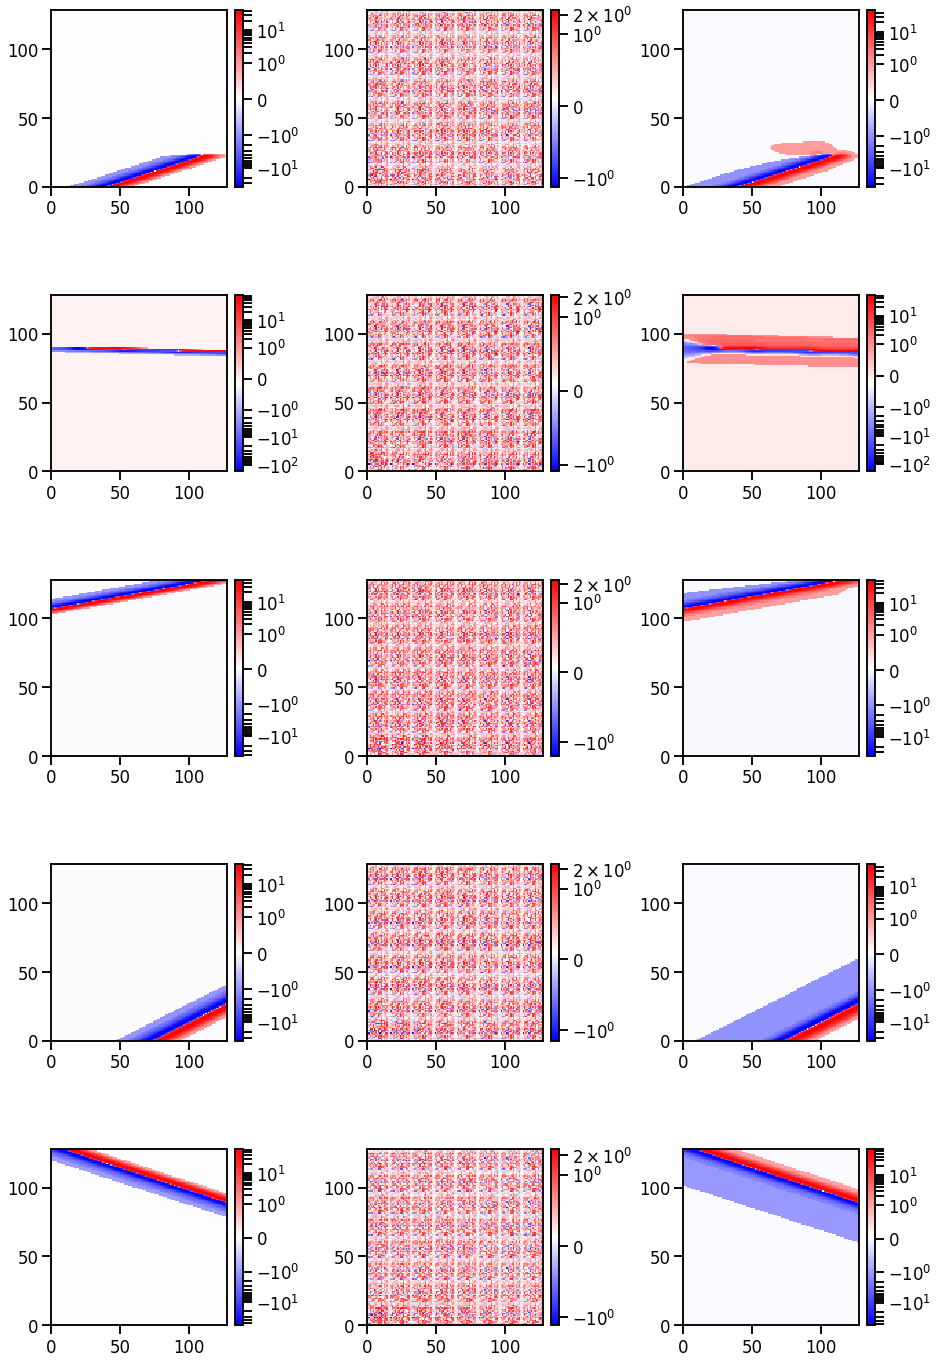

In [37]:
y_ = greedy_decode(model, x_, device)
SimplePlot(x_, y_, y, {'num_samples': 5})